In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)
      
    return cond_entropy / n_estimators

In [3]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [4]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [5]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [6]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [7]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('output/sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [8]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('output/mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [9]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left")
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [10]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('output/sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [11]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return uf(X, y, base = np.exp(1), kappa = 3)
    else:
        raise ValueError("Unrecognized Label!")

In [12]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('output/mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [13]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 20
n1 = 3000
n2 = 6000
num_trials = 20
num_plotted_trials = 10
sample_sizes_d1 = range(300, 1201, 90)
sample_sizes_d2 = range(500, 3001, 250)

# Fake params.
# mus = [i * 0.5 for i in range(1, 3)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 2
# num_plotted_trials = 2
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
#     {
#         'label': 'CART',
#         'title': 'CART Forest',
#         'color': "#1b9e77",
#     },
#     {
#         'label': 'IRF',
#         'title': 'Isotonic Reg. Forest',
#         'color': "#fdae61",
#     },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

### Estimated H(Y | X) versus n, d = 1

In [14]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.30201879, 0.37705088, 0.37834281, 0.36339819, 0.38439456,
         0.3722628 , 0.36336434, 0.33774287, 0.31697253, 0.3607698 ,
         0.39263638, 0.3784456 , 0.34734675, 0.36426955, 0.40474157,
         0.37382583, 0.35817044, 0.36396225, 0.38186707, 0.33436833],
        [0.34132275, 0.39805593, 0.30896859, 0.33941313, 0.32116813,
         0.39913397, 0.36258067, 0.34267634, 0.36779133, 0.37488275,
         0.38917842, 0.39567555, 0.3522616 , 0.3579274 , 0.38110207,
         0.38525748, 0.3117081 , 0.30378953, 0.38103396, 0.32116874],
        [0.3625507 , 0.40136439, 0.35245385, 0.3768303 , 0.37944759,
         0.37240201, 0.36323262, 0.33409993, 0.34997224, 0.34506483,
         0.31920499, 0.39992985, 0.37082387, 0.37269516, 0.28982072,
         0.34862094, 0.36827582, 0.35935789, 0.34534385, 0.33820361],
        [0.3774283 , 0.38097533, 0.33011576, 0.32953467, 0.38924332,
         0.30839359, 0.33157636, 0.37581897, 0.37312523, 0.32518745,
         0.35358596, 0.33866477

### Estimated H(Y | X) versus mu, d = 1

In [15]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[0.52582689, 0.52846776, 0.52325265, 0.53099203, 0.5396423 ,
         0.52116531, 0.54097671, 0.53129239, 0.52765899, 0.5334634 ,
         0.53228426, 0.53488325, 0.52345845, 0.54819833, 0.53710928,
         0.5299042 , 0.53355596, 0.52708202, 0.5275702 , 0.53024929],
        [0.34821179, 0.34160512, 0.35317409, 0.34574213, 0.3523267 ,
         0.33191459, 0.34066211, 0.34338742, 0.34773051, 0.36983807,
         0.34779866, 0.34282147, 0.35715646, 0.35858081, 0.36776439,
         0.35887042, 0.35574009, 0.3519589 , 0.34784711, 0.3411765 ],
        [0.18154503, 0.15832076, 0.18333941, 0.16445056, 0.16269993,
         0.1542952 , 0.17449209, 0.17680976, 0.16062508, 0.17932735,
         0.15817556, 0.18687802, 0.16523128, 0.17074295, 0.15831354,
         0.18236144, 0.17622775, 0.17074283, 0.16999001, 0.17429572],
        [0.06529001, 0.06815154, 0.0679647 , 0.06572677, 0.07379188,
         0.07852568, 0.07907987, 0.06354991, 0.06342198, 0.0653132 ,
         0.0744804 , 0.07075866

### Estimated H(Y | X) versus n, d = 40

In [16]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.3602603 , 0.33115757, 0.39603915, 0.39957871, 0.39580986,
         0.39210858, 0.37404524, 0.40580963, 0.3960272 , 0.35222604,
         0.41243801, 0.38503276, 0.40841095, 0.38757414, 0.39757423,
         0.41422484, 0.37191236, 0.35594276, 0.40503276, 0.36878284],
        [0.36431697, 0.34069618, 0.36434701, 0.38309779, 0.37180205,
         0.37644879, 0.37187528, 0.36954905, 0.38068739, 0.40363011,
         0.4238106 , 0.34102631, 0.33312198, 0.37826177, 0.37019786,
         0.37565242, 0.3917591 , 0.39629555, 0.39930908, 0.3650782 ],
        [0.36883427, 0.38079445, 0.39991213, 0.37047042, 0.38443687,
         0.31836103, 0.35418407, 0.38884946, 0.39934595, 0.34629069,
         0.37220408, 0.35826077, 0.388668  , 0.36959135, 0.37236739,
         0.39546284, 0.34939496, 0.35281336, 0.36435687, 0.36884963],
        [0.38515812, 0.35541279, 0.40069774, 0.3737261 , 0.38829053,
         0.37333849, 0.37175858, 0.35473836, 0.35062838, 0.36095577,
         0.37609927, 0.34128108

### Estimated H(Y | X) versus mu, d = 40

In [17]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[0.54397508, 0.54313446, 0.54544443, 0.54867679, 0.54492529,
         0.53714446, 0.55196865, 0.5430105 , 0.54114386, 0.54451252,
         0.54051722, 0.54630734, 0.54550686, 0.54277084, 0.54187551,
         0.54115608, 0.53905908, 0.53880082, 0.5332728 , 0.54644201],
        [0.34810647, 0.36349975, 0.34318675, 0.35235494, 0.34417485,
         0.35672557, 0.35454504, 0.35331454, 0.34729105, 0.35250514,
         0.35157337, 0.35352983, 0.34412679, 0.3595454 , 0.34874732,
         0.34743884, 0.34736577, 0.34939927, 0.34791805, 0.36580019],
        [0.17222422, 0.17202447, 0.17273927, 0.17364599, 0.16878712,
         0.17243725, 0.17571487, 0.18433456, 0.18180685, 0.173418  ,
         0.17357083, 0.17570684, 0.17158613, 0.17797108, 0.17635481,
         0.17167285, 0.17766428, 0.17073163, 0.16334002, 0.18177537],
        [0.06906722, 0.0659106 , 0.06003745, 0.07056845, 0.06910185,
         0.06469886, 0.06778617, 0.06792516, 0.06511852, 0.070265  ,
         0.06427494, 0.06485724

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


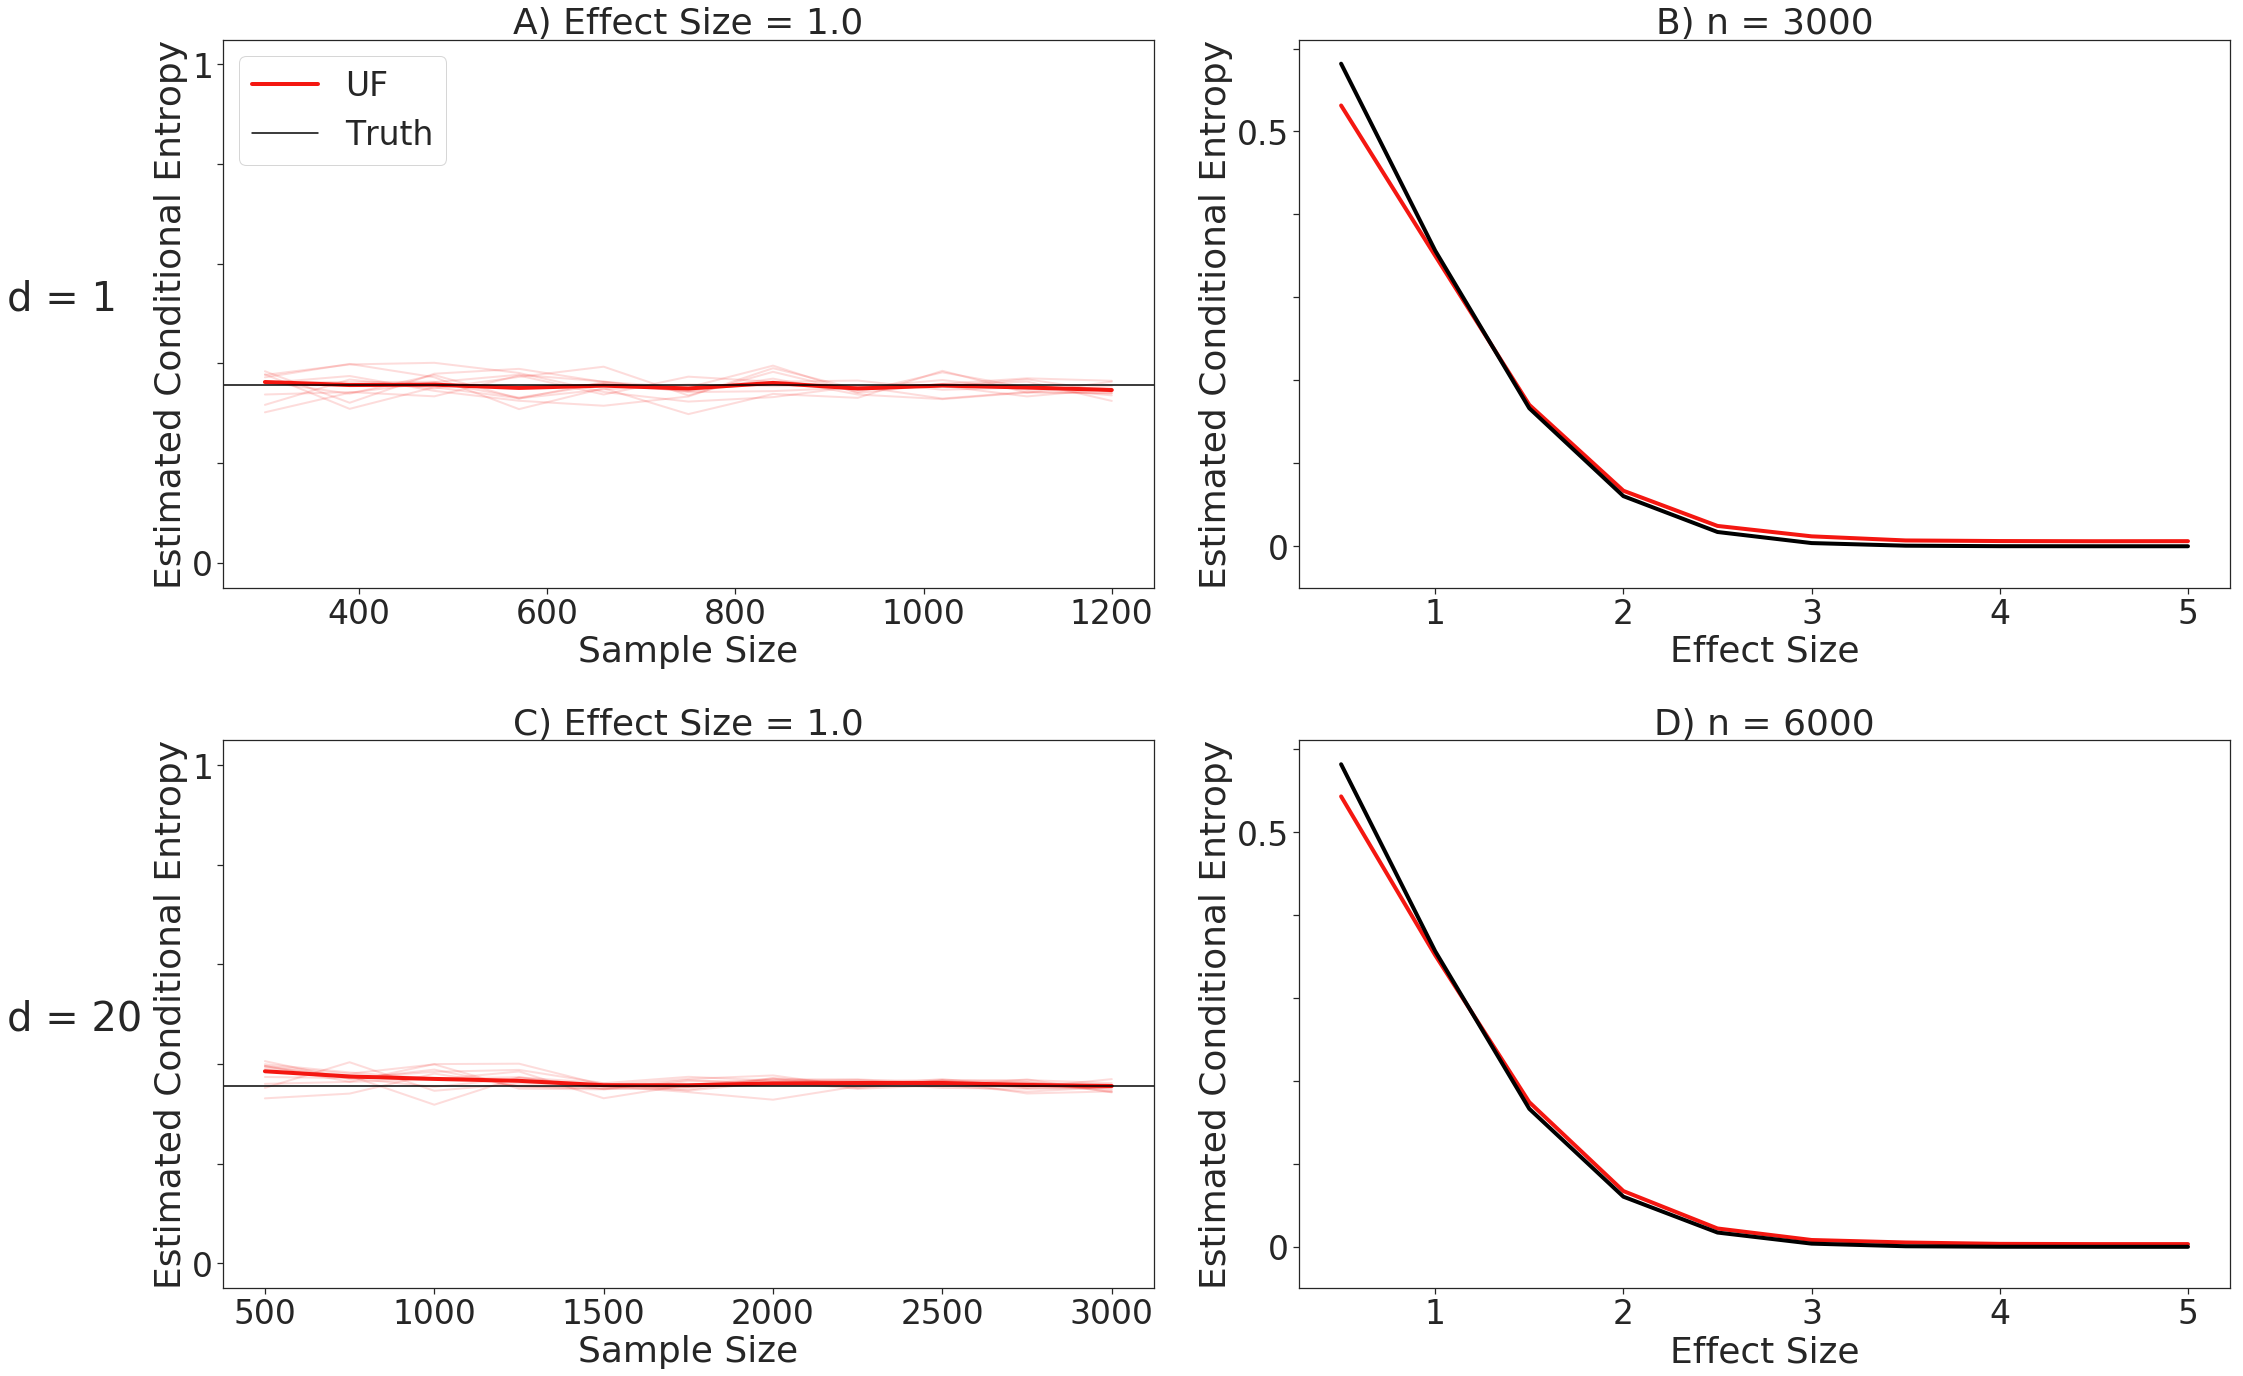

In [18]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)